In [9]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import os
import cv2
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

## Loading Data

In [38]:
import os
import json
import numpy as np
from tqdm import tqdm

data_dir = '/scratch/cpk286/datasets/data_rich_original'

X_list = []
y_list = []

# Iterate through the experiments
for expt in tqdm(sorted(os.listdir(data_dir))):
    experiment_scan = os.path.join(data_dir, expt)
    
    # load mask values
    mask_path = os.path.join(experiment_scan, 'mask.json')
    with open(mask_path, 'r') as f:
        mask = json.load(f)
    
    # Load the feature vectors
    feature_path = os.path.join(experiment_scan, 'features.npy')
    if os.path.exists(feature_path):
        features = np.load(feature_path)  # Shape: (n_windows, 7000)
    else:
        print(f"Feature file missing for {experiment_scan}")
        continue
    
    # Alignment
    for window_id, feature_vector in enumerate(features):
        label_key = f"sample_{window_id + 1}"  # Keys in the mask.json
        if label_key in mask:
            X_list.append(feature_vector)  # Append the feature vector (7000-length)
            y_list.append(mask[label_key])  # Append the corresponding mask values (length 1000)
            # trace_list.append(trace[label_key])
        else:
            print(f"Missing label for {label_key} in {mask_path}")

X_data = np.array(X_list)  
y_data = np.array(y_list)  
# trace_data = np.array(trace_list)

# Check shapes
print(f"Number of feature vectors: {X_data.shape}")
print(f"Number of labels: {y_data.shape}")


100%|██████████| 159/159 [00:00<00:00, 776.01it/s]

Number of feature vectors: (99852, 21)
Number of labels: (99852,)


In [39]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}, Labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test_scaled.shape}, Labels shape: {y_test.shape}")

Training data shape: (79881, 21), Labels shape: (79881,)
Testing data shape: (19971, 21), Labels shape: (19971,)


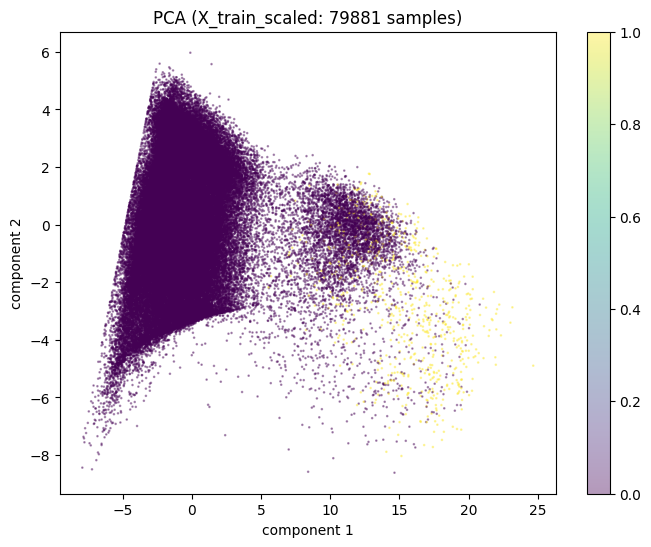

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, marker = '.', s=3, alpha=0.4)
plt.colorbar()
plt.title(f'PCA (X_train_scaled: {X_train_scaled.shape[0]} samples)')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()


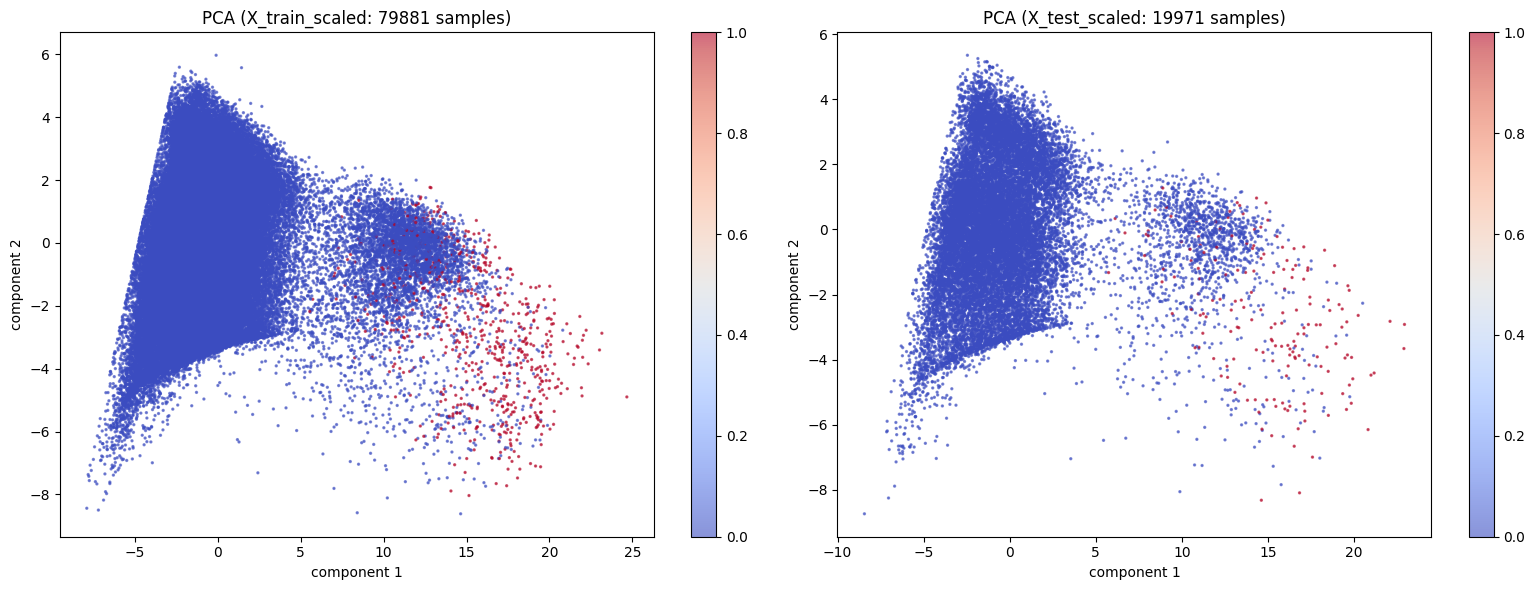

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

X_test_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], cmap='coolwarm', c=y_train, marker='.', s=8, alpha=0.6)
plt.colorbar()
plt.title(f'PCA (X_train_scaled: {X_train_scaled.shape[0]} samples)')
plt.xlabel('component 1')
plt.ylabel('component 2')

plt.subplot(1, 2, 2)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], cmap='coolwarm', c=y_test, marker='.', s=8, alpha=0.6)
plt.colorbar()
plt.title(f'PCA (X_test_scaled: {X_test_scaled.shape[0]} samples)')
plt.xlabel('component 1')
plt.ylabel('component 2')

# Show the plots
plt.tight_layout()
plt.show()

### Grid Search

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import logging
from sklearn.metrics import make_scorer, f1_score

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

f1_scorer = make_scorer(f1_score, average='binary')  
# f1_class1_scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(
    SVC(class_weight='balanced'),
    param_grid,
    scoring=f1_scorer,
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Increase verbosity for progress monitoring
    n_jobs=-1  # Enable parallel execution
)

grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   9.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   9.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  10.1s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  10.2s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  10.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  12.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  12.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  12.8s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   9.8s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   9.8s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  10.1s
[CV] END ...................C=0.1, gamma=auto, k

In [45]:
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_scaled)

from sklearn.metrics import classification_report
print("Test Classification Report:\n", classification_report(y_test, y_pred))

Test Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     19797
         1.0       0.48      0.82      0.60       174

    accuracy                           0.99     19971
   macro avg       0.74      0.90      0.80     19971
weighted avg       0.99      0.99      0.99     19971



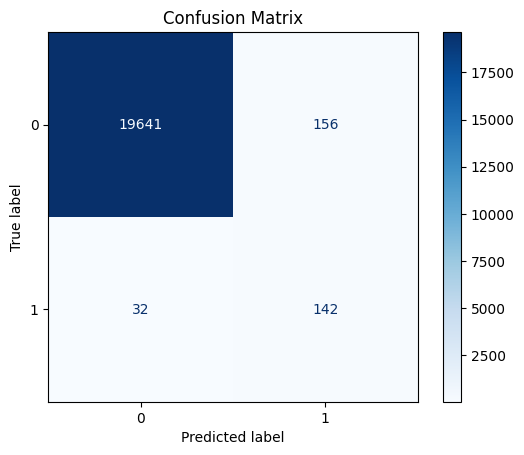

In [46]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=[0,1])
disp.plot(cmap='Blues', values_format = "d")
plt.title(f'Confusion Matrix')
plt.show()

In [50]:
# save model
model_filename = "/home/cpk286/NF-Volt/models/svm_model_orig_rich_100k.pkl"
with open(model_filename, "wb") as model_file:
    pickle.dump(best_svm, model_file)

### Training
(alternatively): by manually setting the params

In [47]:
# if grid search 
# svc_model = best_svm

In [48]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.svm import SVC
# f1_scorer = make_scorer(f1_score, average='binary')  

svc_model = SVC(C=100, kernel='rbf', gamma='scale', class_weight='balanced', probability=True)
# Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
# Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'} for rich

svc_model.fit(X_train_scaled, y_train)

SVC(C=100, class_weight='balanced', probability=True)

In [15]:
# load model (optional)
# with open('/home/cpk286/NF-Volt/models/svm_model_100k.pkl', "rb") as model_file:
#     svc_model = pickle.load(model_file)

In [49]:
y_pred = svc_model.predict(X_test_scaled)

from sklearn.metrics import classification_report
print("Test Classification Report:\n", classification_report(y_test, y_pred))

Test Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     19797
         1.0       0.48      0.82      0.60       174

    accuracy                           0.99     19971
   macro avg       0.74      0.90      0.80     19971
weighted avg       0.99      0.99      0.99     19971



In [51]:
y_probs = svc_model.predict_proba(X_test_scaled)
# f1 = f1_score(y_test, y_pred, average='binary')  
# print("F1 Score:", f1)

In [52]:
y_probs.shape

(19971, 2)

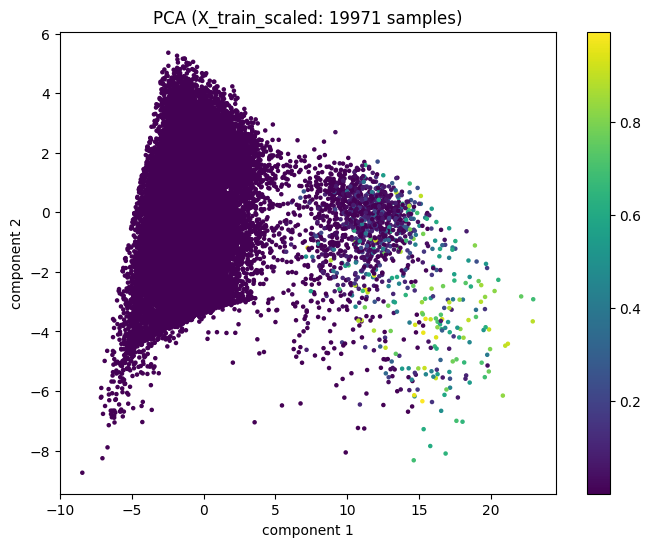

In [53]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_probs[:,1], alpha=1, marker=".", s = 20)
plt.colorbar()
plt.title(f'PCA (X_train_scaled: {X_test_scaled.shape[0]} samples)')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()



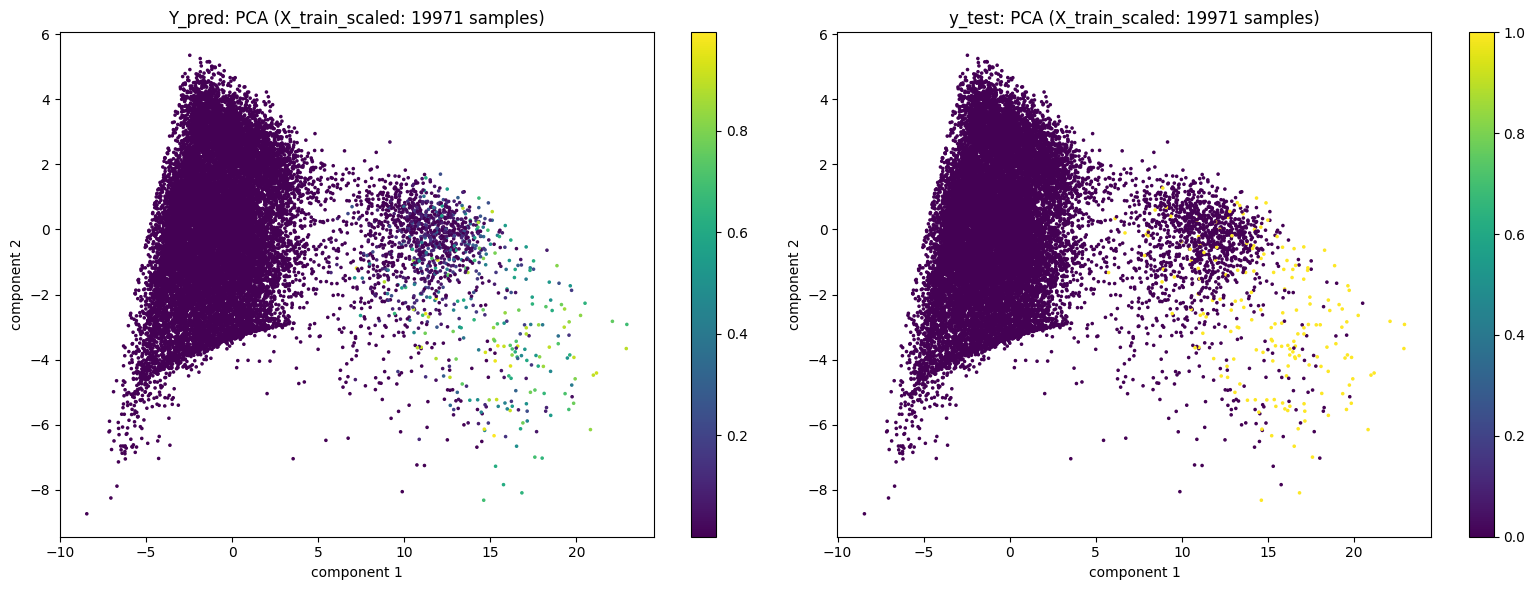

In [54]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_probs[:,1], alpha=1, marker=".", s = 10)
plt.colorbar()
plt.title(f'Y_pred: PCA (X_train_scaled: {y_probs.shape[0]} samples)')
plt.xlabel('component 1')
plt.ylabel('component 2')


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, alpha=1, marker=".", s = 10)
plt.colorbar()
plt.title(f'y_test: PCA (X_train_scaled: {X_test_scaled.shape[0]} samples)')
plt.xlabel('component 1')
plt.ylabel('component 2')


plt.tight_layout()
plt.show()

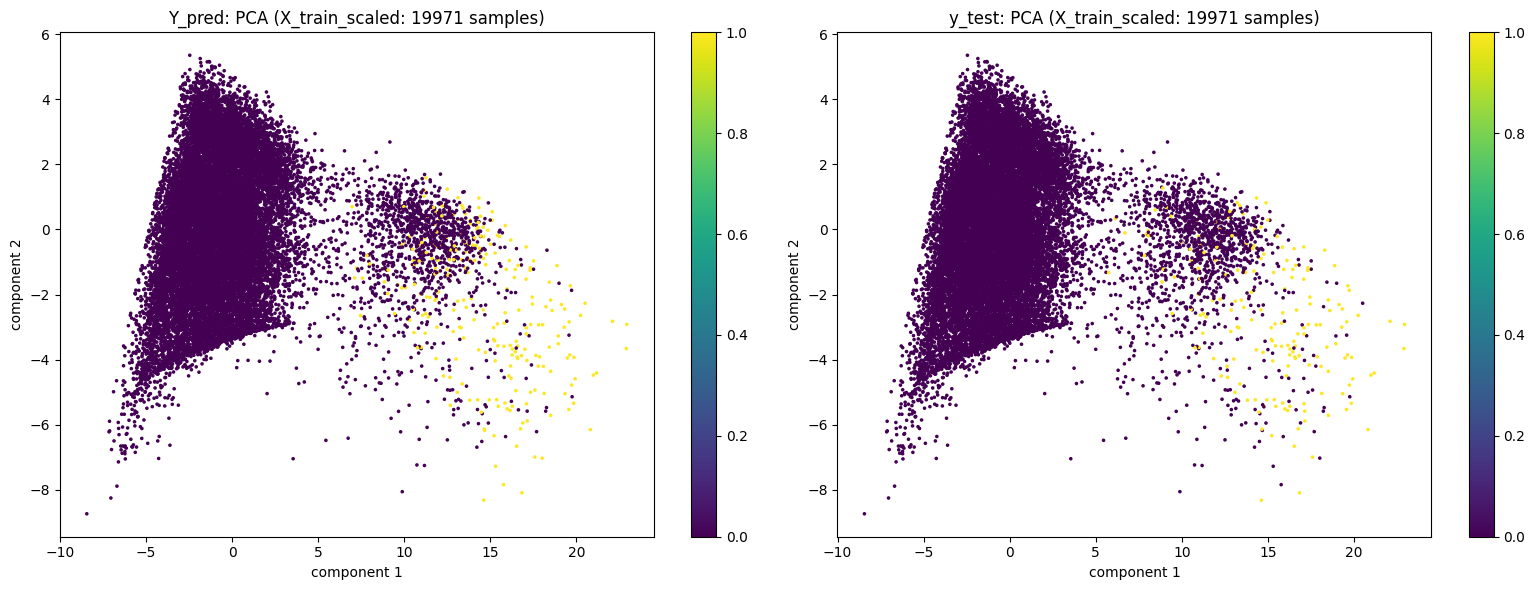

Test Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     19797
         1.0       0.53      0.76      0.62       174

    accuracy                           0.99     19971
   macro avg       0.76      0.88      0.81     19971
weighted avg       0.99      0.99      0.99     19971



In [55]:
threshold = 0.25
# y_thres = np.zeros_like(y_probs)

y_thres = (y_probs[:, 1] >= threshold).astype(int)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_thres, alpha=1, marker=".", s = 10)
plt.colorbar()
plt.title(f'Y_pred: PCA (X_test_scaled: {y_thres.shape[0]} samples)')
plt.xlabel('component 1')
plt.ylabel('component 2')


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, alpha=1, marker=".", s = 10)
plt.colorbar()
plt.title(f'y_test: PCA (X_test_scaled: {X_test_scaled.shape[0]} samples)')
plt.xlabel('component 1')
plt.ylabel('component 2')


plt.tight_layout()
plt.show()


print("Test Classification Report:\n", classification_report(y_test, y_thres))

In [56]:
from sklearn.metrics import classification_report
print("Test Classification Report:\n", classification_report(y_test, y_pred))

Test Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     19797
         1.0       0.48      0.82      0.60       174

    accuracy                           0.99     19971
   macro avg       0.74      0.90      0.80     19971
weighted avg       0.99      0.99      0.99     19971



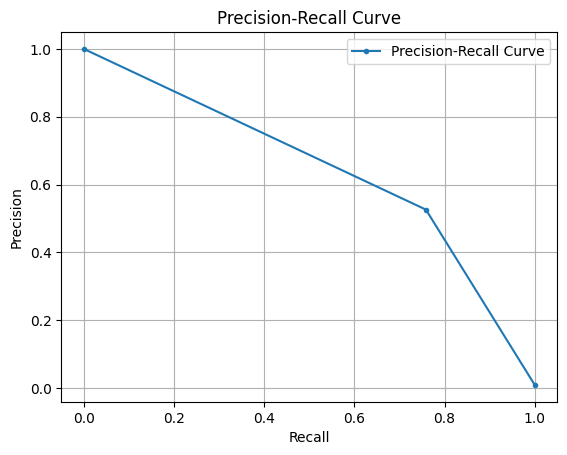

In [57]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_thres)

plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


/home/cpk286/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


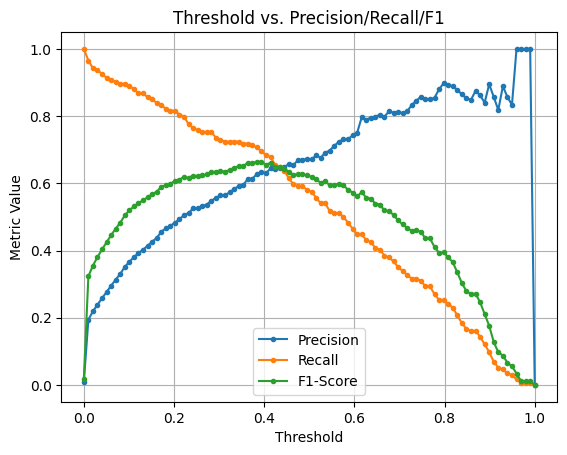

In [58]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0, 1, 100)  # Generate thresholds
precisions, recalls, f1_scores = [], [], []

for threshold in thresholds:
    y_pred = (y_probs[:, 1] >= threshold).astype(int)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Plot Threshold vs. Metrics
plt.plot(thresholds, precisions, label='Precision', marker='.')
plt.plot(thresholds, recalls, label='Recall', marker='.')
plt.plot(thresholds, f1_scores, label='F1-Score', marker='.')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Threshold vs. Precision/Recall/F1')
plt.legend()
plt.grid()
plt.show()


In [25]:
model_filename = "/home/cpk286/NF-Volt/models/svm_model_orig_100K_proba.pkl"
with open(model_filename, "wb") as model_file:
    pickle.dump(svc_model, model_file)